In [101]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import functools
import community

from scipy import sparse
from scipy.sparse import linalg
import time
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from math import sqrt
import pandas as pd
from shapely.ops import cascaded_union
pd.set_option('precision', 10)

# Computing landmarkness on paths and nodes

In [102]:
#initialise path, names, etc.

city_name = 'London'
folder_ouptut ='Outputs/'+city_name+'/'
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

In [103]:
# try reading nodes, paths, landmarks and sight_lines
# At this point, every element has already been extracted

nodes = gpd.read_file(folder_ouptut+city_name+'_nodes.shp', driver='ESRI Shapefile')
paths = gpd.read_file(folder_ouptut+city_name+'_paths.shp', driver='ESRI Shapefile')
landmarks = gpd.read_file(folder_ouptut+city_name+'_landmarks.shp', driver='ESRI Shapefile')
sight_lines = gpd.read_file(folder_ouptut+city_name+'_sight_lines.shp', driver='ESRI Shapefile')

In [104]:
# assigning a decision point score per each node
# each node get the score of the best local landmark

spatial_index = landmarks.sindex
nodes['dp'] = 0.0

for row in nodes.itertuples():
    
    g = row[-2] #geometry
    fil = g.buffer(50)    
    
    possible_matches_index = list(spatial_index.intersection(fil.bounds))
    possible_matches = landmarks.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(fil)]

    if (len(precise_matches)==0): continue
    
    precise_matches = precise_matches.sort_values(by='pragmatic', ascending=False).reset_index()
    score = precise_matches['pragmatic'].loc[0]
    nodes.set_value(row[0], 'dp', score)

In [105]:
# keeping relevant landmarks and the sight lines that point at them

relevant = landmarks[landmarks.score_scal > 0.5]
index_relevant = landmarks['buildingID'].values.astype(int) 
sight_torelevant = sight_lines[sight_lines['buildingID'].isin(index_relevant)]

In [106]:
# per each node, the sight lines to the relevant landmarks are extracted. 
# The visibility score of each node is the sum of the score of the visible landmarks visible from it, regardless the direction

nodes['dist'] = 0.0
nodes['visible_landmarks'] = 'NA' 

for row in nodes.itertuples():
    sight_node = sight_torelevant[sight_torelevant['nodeID'] == row[0]] 
    index_relevant_fromNode = list(sight_node['buildingID'].values.astype(int))
    relevant_fromNode = relevant[relevant['buildingID'].isin(index_relevant_fromNode)] 
    score = relevant_fromNode['score_scal'].sum()
    nodes.set_value(row[0], 'dist', score)   
    nodes.set_value(row[0], 'visible_landmarks', list(relevant_fromNode['buildingID'].values.astype(int)))

In [107]:
def scaling(df, i):
    df[i+'_sc'] = (df[i]-df[i].min())/(df[i].max()-df[i].min())
    
def inverse_scaling(df, i):
    df[i+'_sc'] = 1-(df[i]-df[i].min())/(df[i].max()-df[i].min())

In [108]:
# rescale to have higher values for lower values and viceversa

col = ['dp', 'dist']

for i in col:
    inverse_scaling(nodes, i)

In [109]:
# assigning scores to edges, based on the best reassuring landmark along each of them

spatial_index = landmarks.sindex
paths['reass'] = 0.0

for row in paths.itertuples():
    
    g = row[-2] #geometry
    fil = g.buffer(25)    
    
    possible_matches_index = list(spatial_index.intersection(fil.bounds))
    possible_matches = landmarks.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(fil)]

    if (len(precise_matches)==0): continue
    
    precise_matches = precise_matches.sort_values(by='score_scal', ascending=False).reset_index()
    score = precise_matches['score_scal'].loc[0]
    paths.set_value(row[0], 'reass', score)

In [110]:
# assigning nodes' score to each edge

paths['nS_vis'] = 0.0
paths['nS_dp'] = 0.0

for row in paths.itertuples():
    u = row[2]
    v = row[3]
    nodes_path = nodes[nodes['nodeID'].isin([u,v])]
    paths.set_value(row[0], 'nS_vis', nodes_path['dp'].sum())
    paths.set_value(row[0], 'nS_dp', nodes_path['dist'].sum())

In [111]:
# scaling raw scores as before
col = ['reass', 'nS_vis', 'nS_dp'] 

for i in col:
    inverse_scaling(paths, i)

# scaling distances
scaling(paths, 'length')

In [112]:
paths['land'] = paths['reass_sc']+ paths['nS_vis_sc'] + paths['nS_dp_sc']
scaling(paths, 'land')

In [113]:
paths['dist&land'] = paths['length_sc']+paths['land_sc']
paths.head()

streetID     u     v  key          length        Eb          Ab  \
0         0   886   199    0   90.7584444386    3335.0    4665.250   
1         1  2718  1085    0  307.5254896358   11725.0   69207.500   
2         2  1861  1534    0  131.1818512142   12308.0   73542.875   
3         3  3213  3486    0  148.7149451569   27731.0   20572.000   
4         4  3698   875    0  261.7112357594  148165.0  331380.000   

      Ab_scaled     Eb_scaled  \
0  0.0017360336  0.0028367166   
1  0.0257535061  0.0099731639   
2  0.0273667866  0.0104690577   
3  0.0076552560  0.0235877022   
4  0.1233131793  0.1260276186   

                                            geometry         reass  \
0  LINESTRING (528421.0000001118 180948.999999571...  0.3705479116   
1  LINESTRING (533740.0500001372 181263.939999453...  0.2733731099   
2  LINESTRING (533835.3200001377 180907.189999451...  0.3857464628   
3  LINESTRING (528136.0000001106 180780.999999577...  0.3467186744   
4  LINESTRING (532764.1500001322 180312.289999477...  0.5921092425   

         nS_vis         nS_dp      reass_sc     nS_vis_sc      nS_dp_sc  \
0  1.9723565462  0.0000000000  0.6294520884  0.0138217269  1.0000000000   
1  0.4883505917  0.0000000000  0.7266268901  0.7558247041  1.0000000000   
2  1.8936760355  0.5921092425  0.6142535372  0.0531619822  0.9825898069   
3  1.1590740990  1.0508962869  0.6532813256  0.4204629505  0.9690997777   
4  1.9169068959  5.8909224753  0.4078907575  0.0415465521  0.8267851770   

      length_sc          land       land_sc     dist&land  
0  0.1101898706  1.6432738153  0.4544893884  0.5646792590  
1  0.3741241580  2.4824515943  0.8498752665  1.2239994246  
2  0.1594091745  1.6500053263  0.4576609981  0.6170701726  
3  0.1807573672  2.0428440537  0.6427503667  0.8235077338  
4  0.3183409903  1.2762224866  0.2815499761  0.5998909664

# Computing edge betweenness 
## Primal graph

In [114]:
nodes = nodes.drop(nodes[['visible_landmarks']],axis=1)
nodes.gdf_name = 'Nodes_list' #for OSMNx
paths.gdf_name = 'Edges_list' #for OSMNx

In [115]:
G = ox.gdfs_to_graph(nodes, paths)
t = G.nodes()
pos = {}

for l, item in enumerate(t): pos[l] = (t[l]['x'],t[l]['y'])

Ng = nx.Graph() #Empty graph
Ng = Ng.to_undirected()
Ng.add_nodes_from(pos.keys()) #Add nodes preserving coordinates

for i, item in enumerate(Ng.nodes()):
    Ng.node[i]['x']=pos[i][0]
    Ng.node[i]['y']=pos[i][1]

for i, item in enumerate(G.edges()):
    Ng.add_edge(item[0], item[1])
    Ng[item[0]][item[1]]['land_sc']=G[item[0]][item[1]][0]['land_sc']
    Ng[item[0]][item[1]]['dist&land']=G[item[0]][item[1]][0]['dist&land']
    Ng[item[0]][item[1]]['streetID']=G[item[0]][item[1]][0]['streetID']

In [116]:
Lb = nx.edge_betweenness_centrality(Ng, weight='land_sc', normalized=False) 

In [117]:
ELb = nx.edge_betweenness_centrality(Ng, weight='dist&land', normalized=False)

In [118]:
def to_df(list_dict, list_col):
    
    df = pd.DataFrame(list_dict).T
    df.columns = ['d{}'.format(i) for i, col in enumerate(df, 1)]
    df.columns = list_col
    
    return(df)

In [119]:
edge_id={}
for i, g in Ng.edges(): edge_id[(i,g)]=Ng[i][g]['streetID']

edges_df = to_df([Lb, ELb, edge_id], ["Lb", "ELb","streetID"])
edges_df.streetID = edges_df.streetID.astype(int)

In [120]:
paths_tmp = pd.merge(paths, edges_df, left_on = 'streetID', right_on = 'streetID', how='left')

In [172]:
def plotGDF(gdf, column, title):
    f, ax = plt.subplots(1, figsize=(15, 15))
    gdf.plot(ax=ax, column=column, cmap='OrRd', scheme='Fisher_Jenks', linewidth=0.5, legend=True)
    f.suptitle(title)
    plt.axis('equal')
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
    ax.set_axis_off()

In [122]:
f, ax = plt.subplots(1, figsize=(10, 10))
nodes.plot(ax=ax, column='dist', cmap='OrRd', scheme='Fisher_Jenks', markersize=5)
plt.axis('equal')
ax.set_axis_off()

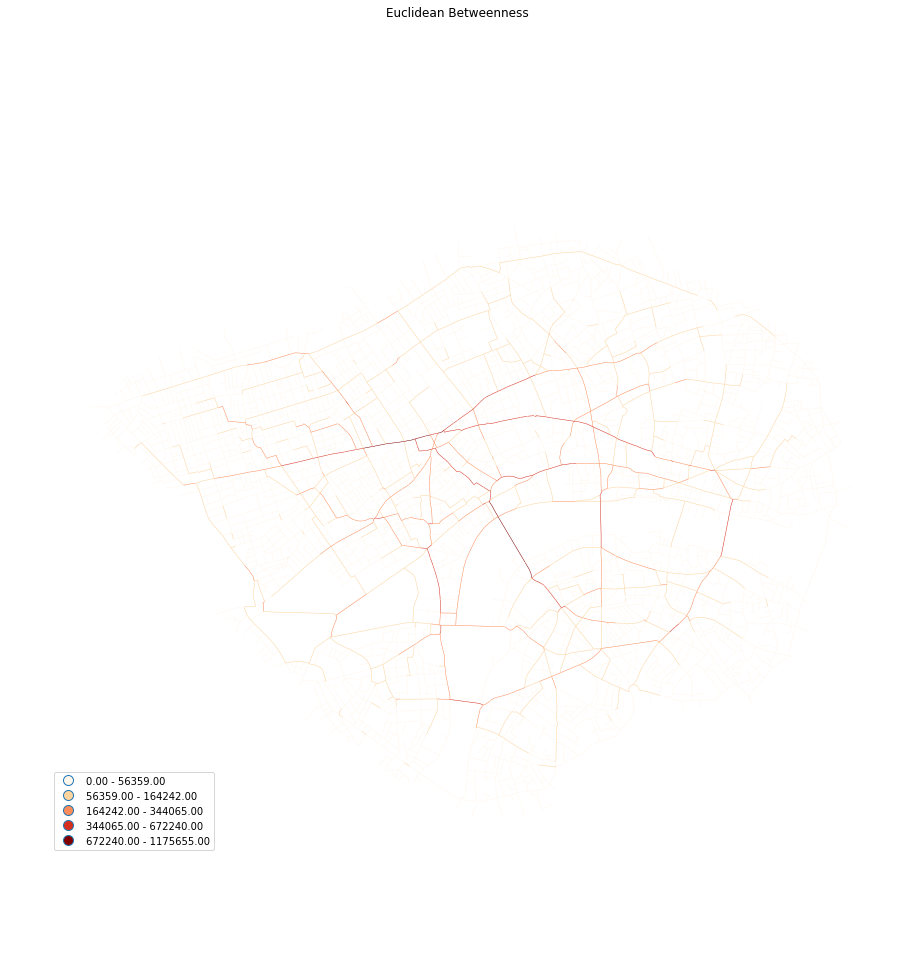

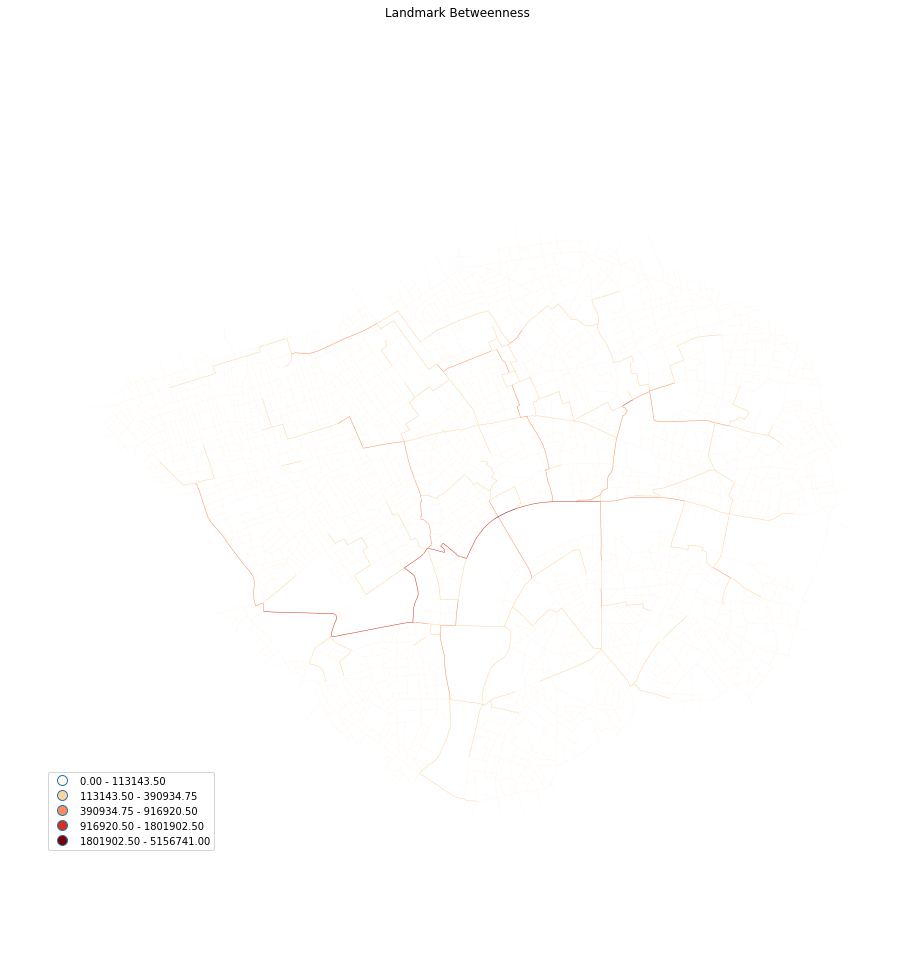

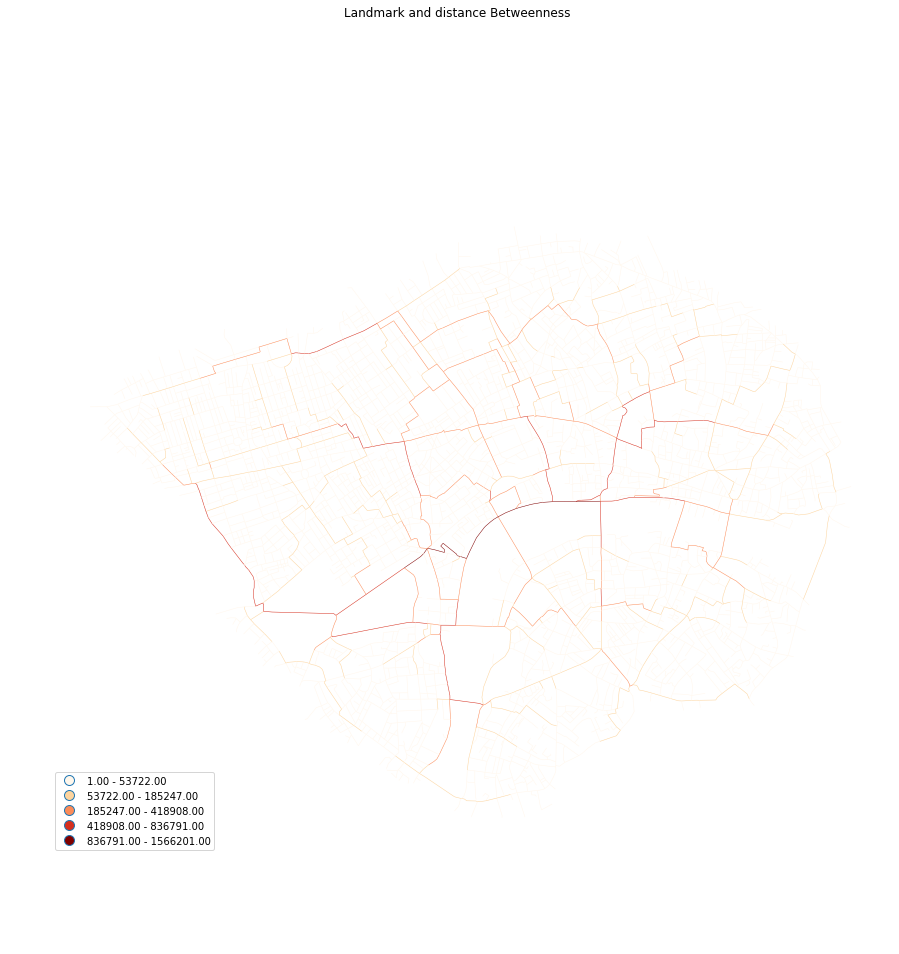

In [173]:
plotGDF(paths_tmp,'Eb', 'Euclidean Betweenness')
plotGDF(paths_tmp,'Lb', 'Landmark Betweenness')
plotGDF(paths_tmp,'ELb', 'Landmark and distance Betweenness')

In [124]:
paths.head()

streetID     u     v  key          length        Eb          Ab  \
0         0   886   199    0   90.7584444386    3335.0    4665.250   
1         1  2718  1085    0  307.5254896358   11725.0   69207.500   
2         2  1861  1534    0  131.1818512142   12308.0   73542.875   
3         3  3213  3486    0  148.7149451569   27731.0   20572.000   
4         4  3698   875    0  261.7112357594  148165.0  331380.000   

      Ab_scaled     Eb_scaled  \
0  0.0017360336  0.0028367166   
1  0.0257535061  0.0099731639   
2  0.0273667866  0.0104690577   
3  0.0076552560  0.0235877022   
4  0.1233131793  0.1260276186   

                                            geometry         reass  \
0  LINESTRING (528421.0000001118 180948.999999571...  0.3705479116   
1  LINESTRING (533740.0500001372 181263.939999453...  0.2733731099   
2  LINESTRING (533835.3200001377 180907.189999451...  0.3857464628   
3  LINESTRING (528136.0000001106 180780.999999577...  0.3467186744   
4  LINESTRING (532764.1500001322 180312.289999477...  0.5921092425   

         nS_vis         nS_dp      reass_sc     nS_vis_sc      nS_dp_sc  \
0  1.9723565462  0.0000000000  0.6294520884  0.0138217269  1.0000000000   
1  0.4883505917  0.0000000000  0.7266268901  0.7558247041  1.0000000000   
2  1.8936760355  0.5921092425  0.6142535372  0.0531619822  0.9825898069   
3  1.1590740990  1.0508962869  0.6532813256  0.4204629505  0.9690997777   
4  1.9169068959  5.8909224753  0.4078907575  0.0415465521  0.8267851770   

      length_sc          land       land_sc     dist&land  
0  0.1101898706  1.6432738153  0.4544893884  0.5646792590  
1  0.3741241580  2.4824515943  0.8498752665  1.2239994246  
2  0.1594091745  1.6500053263  0.4576609981  0.6170701726  
3  0.1807573672  2.0428440537  0.6427503667  0.8235077338  
4  0.3183409903  1.2762224866  0.2815499761  0.5998909664

## Dual graph

In [125]:
nodes_dual = gpd.read_file(folder_ouptut+city_name+'_nodesDual.shp', driver='ESRI Shapefile')
edges_dual = gpd.read_file(folder_ouptut+city_name+'_edgesDual.shp', driver='ESRI Shapefile')

In [126]:
# assigning landmark scores to links between centroids (this is artificial)

edges_dual.u = edges_dual.u.astype(int)
edges_dual.v = edges_dual.v.astype(int)
edges_dual.key = edges_dual.key.astype(int)

for row in edges_dual.itertuples():
    landmarkness_u = paths['land'][paths.streetID==row[1]].loc[row[1]] #row[1]==u
    landmarkness_v = paths['land'][paths.streetID==row[2]].loc[row[2]] #row[2]==v
    landmarkness = landmarkness_u+landmarkness_v
    edges_dual.set_value(row[0], 'land', landmarkness)

In [127]:
scaling(edges_dual, 'rad')

In [128]:
# scaling raw scores and deviation

scaling(edges_dual, 'land')  
edges_dual['angle&land'] = edges_dual['rad_sc']+edges_dual['land_sc']

In [129]:
nodes_dual.gdf_name = 'Dual_list'
Gr = ox.gdfs_to_graph(nodes_dual, edges_dual)
    
n = Gr.nodes()
pos = {}
    
print(len(n))
for l, item in enumerate(n): pos[l] = (n[l]['x'],n[l]['y'],n[l]['streetID'])
        
DG = nx.Graph() #Empty graph
DG = DG.to_undirected()
DG.add_nodes_from(pos.keys()) #Add nodes preserving coordinates
    
for i, item in enumerate(DG.nodes()):
    DG.node[i]['x']=pos[i][0]
    DG.node[i]['y']=pos[i][1]
    DG.node[i]['streetID']=pos[i][2]
        
for i, item in enumerate(Gr.edges()):
    DG.add_edge(item[0], item[1])
    DG[item[0]][item[1]]['angle&land'] = Gr[item[0]][item[1]][0]['angle&land']

5297


In [130]:
ALb = nx.betweenness_centrality(DG, weight='angle&land', normalized=False)

In [131]:
def id_dict(ed, graph):
    
    view = ed.items()
    ed_list = list(view)
    ed_dict = {}

    for p in ed_list:
        ed_dict[graph.node[p[0]]['streetID']]=p[1] #streetID and Edge betweenness
        
    return(ed_dict)

In [132]:
ALb_dict = id_dict(ALb, DG)
ALb_df = to_df([ALb_dict], ["ALb"])

In [133]:
paths_tmp = pd.merge(paths_tmp, ALb_df, left_on="streetID", right_index=True, how='left')

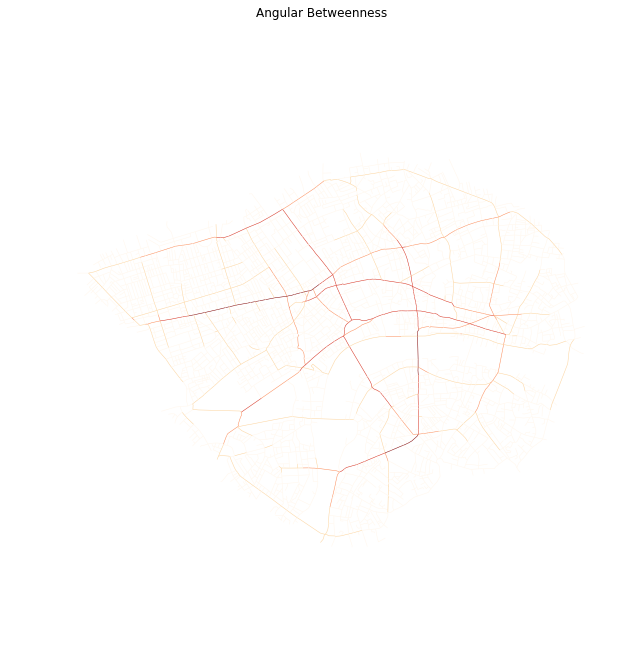

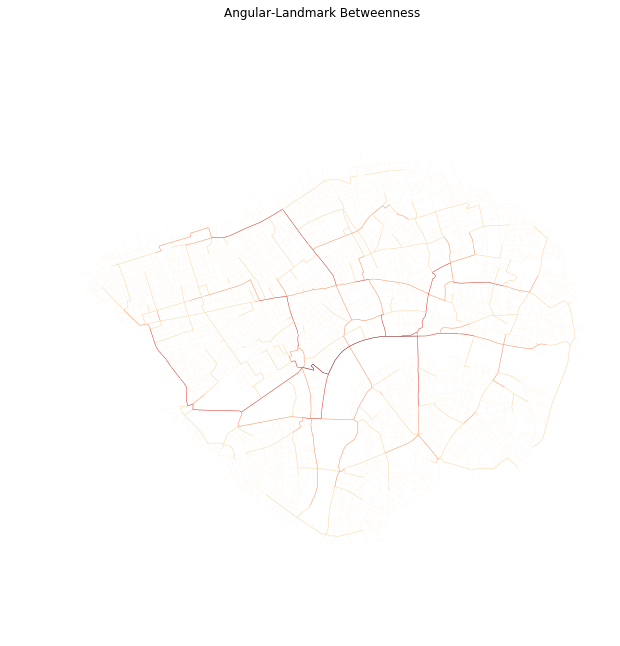

In [134]:
plot(paths_tmp,'Ab', 'Angular Betweenness')
plot(paths_tmp,'ALb', 'Angular-Landmark Betweenness')

In [135]:
paths_tmp.to_file(folder_ouptut+city_name+'_paths.shp', driver='ESRI Shapefile')

In [136]:
nodes.to_file(folder_ouptut+city_name+'_nodes.shp', driver='ESRI Shapefile')

In [141]:
paths_tmp.head()

streetID     u     v  key          length        Eb          Ab  \
0         0   886   199    0   90.7584444386    3335.0    4665.250   
1         1  2718  1085    0  307.5254896358   11725.0   69207.500   
2         2  1861  1534    0  131.1818512142   12308.0   73542.875   
3         3  3213  3486    0  148.7149451569   27731.0   20572.000   
4         4  3698   875    0  261.7112357594  148165.0  331380.000   

      Ab_scaled     Eb_scaled  \
0  0.0017360336  0.0028367166   
1  0.0257535061  0.0099731639   
2  0.0273667866  0.0104690577   
3  0.0076552560  0.0235877022   
4  0.1233131793  0.1260276186   

                                            geometry    ...         reass_sc  \
0  LINESTRING (528421.0000001118 180948.999999571...    ...     0.6294520884   
1  LINESTRING (533740.0500001372 181263.939999453...    ...     0.7266268901   
2  LINESTRING (533835.3200001377 180907.189999451...    ...     0.6142535372   
3  LINESTRING (528136.0000001106 180780.999999577...    ...     0.6532813256   
4  LINESTRING (532764.1500001322 180312.289999477...    ...     0.4078907575   

      nS_vis_sc      nS_dp_sc     length_sc          land       land_sc  \
0  0.0138217269  1.0000000000  0.1101898706  1.6432738153  0.4544893884   
1  0.7558247041  1.0000000000  0.3741241580  2.4824515943  0.8498752665   
2  0.0531619822  0.9825898069  0.1594091745  1.6500053263  0.4576609981   
3  0.4204629505  0.9690997777  0.1807573672  2.0428440537  0.6427503667   
4  0.0415465521  0.8267851770  0.3183409903  1.2762224866  0.2815499761   

      dist&land        Lb      ELb       ALb  
0  0.5646792590   9467.75   7336.0    6683.0  
1  1.2239994246  90887.25  78938.0  211132.0  
2  0.6170701726  58215.00  47811.0  200482.0  
3  0.8235077338  71058.75  60588.0  150508.0  
4  0.5998909664  59994.00  64346.0  142359.0  

[5 rows x 23 columns]

In [179]:
pedestrians = pd.read_csv("C:/Users/g_filo01/sciebo/GIS Data/Simulation/pedestrians_eucl.csv")

In [162]:
pedestrians.dtypes

streetID           int64
euclidean          int64
topological        int64
angular            int64
euclideanLand      int64
topologicalLand    int64
angularLand        int64
landmark           int64
total              int64
dtype: object

In [154]:
colPed = ["euclidean", "topological", "angular", "landmark", "euclideanLand", "topologicalLand", "angularLand"]

In [180]:
paths_data = pd.merge(paths_tmp, pedestrians, left_on="streetID", right_on="streetID", how='left')

In [184]:
paths_data['euclideanDiff']=paths_data['euclidean']-paths_data['euclideanLand']

In [187]:
len(paths_data)

5297

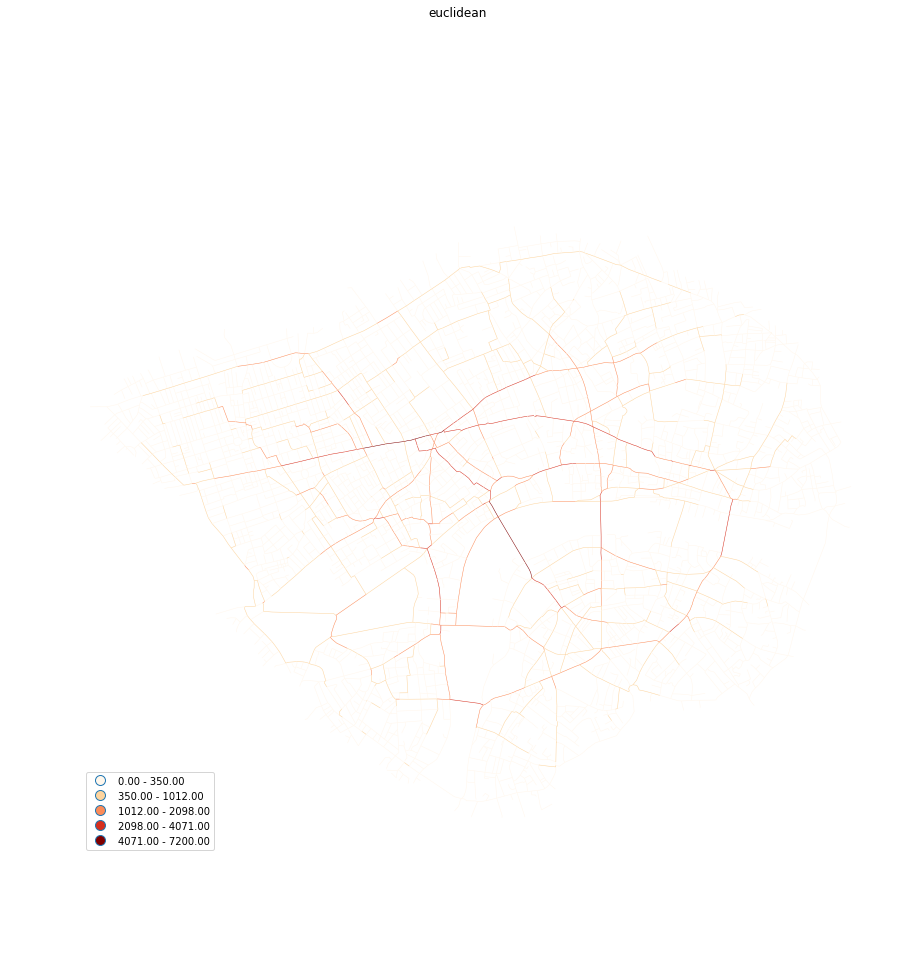

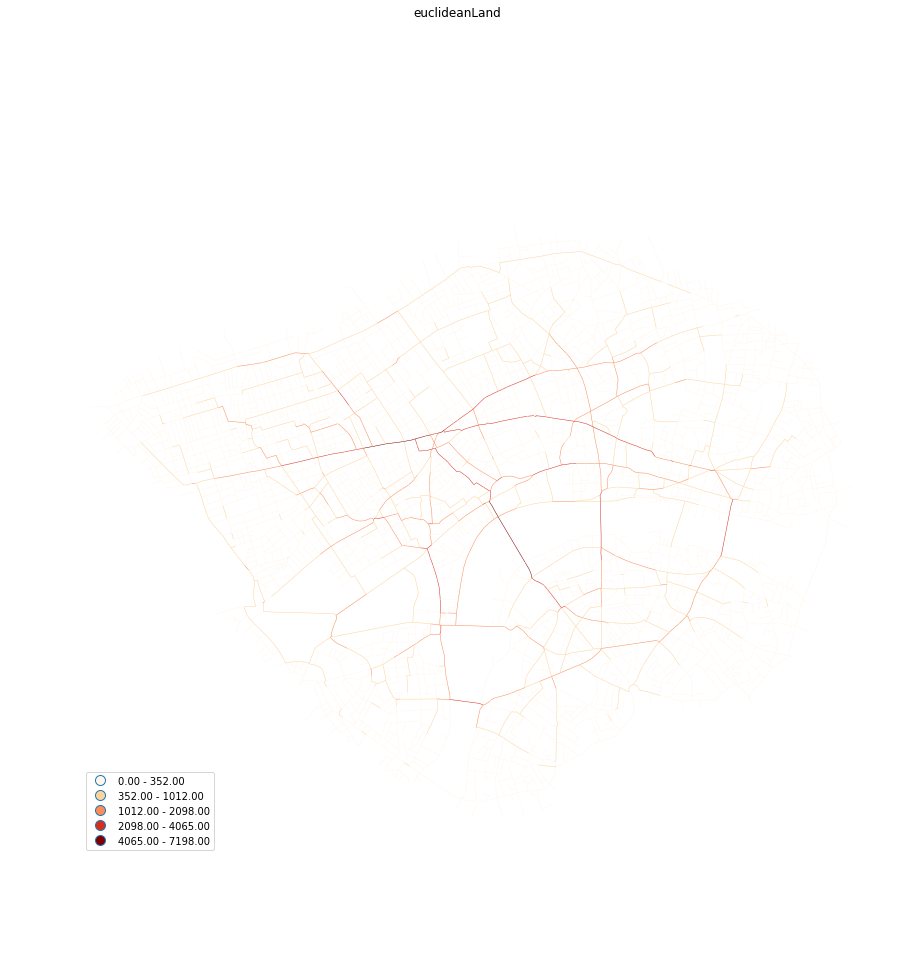

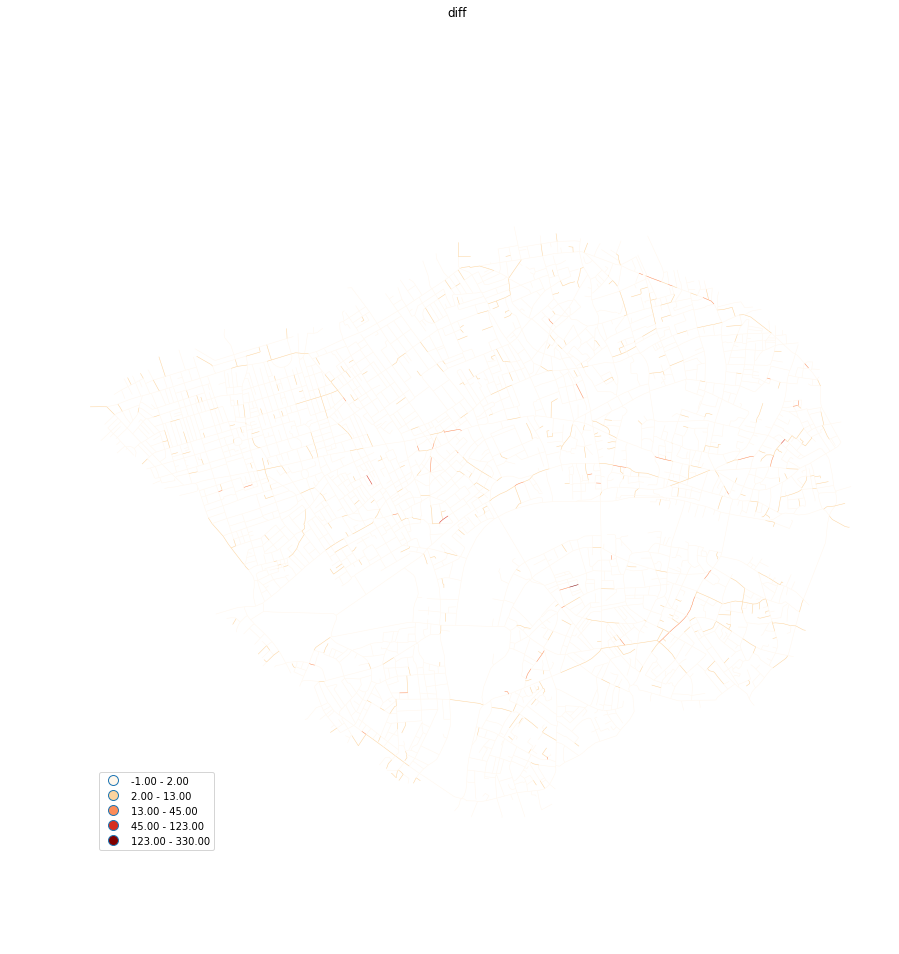

In [185]:
plotGDF(paths_data,"euclidean","euclidean")
# plotGDF(paths_data,"topological","topological")
# plotGDF(paths_data,"angular","angular")
plotGDF(paths_data,"euclideanLand","euclideanLand")
plotGDF(paths_data,"euclideanDiff","diff")
# plotGDF(paths_data,"topologicalLand","topologicalLand")
# plotGDF(paths_data,"angularLand","angularLand")
# plotGDF(paths_data,"landmark","landmark")

euclidean


AttributeError: 'DataFrame' object has no attribute 'dtype'

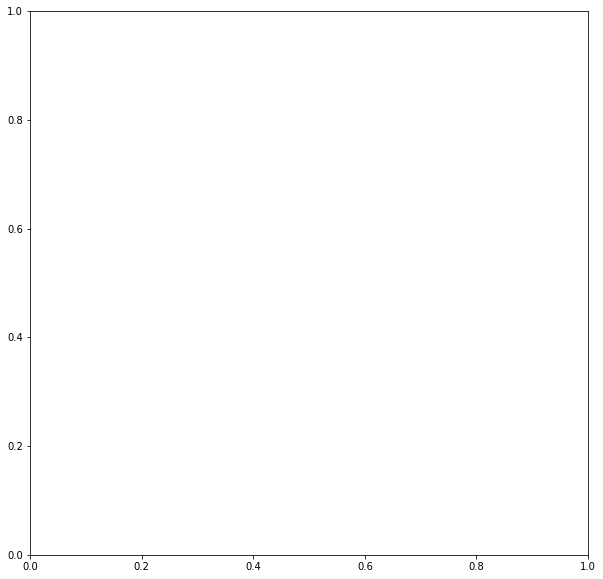

In [160]:
for i in colPed:
    print(i)
    plotGDF(paths_data, colPed, colPed)